# Linear Regression: Overfitting and Regularization

In this notebook, we will observe how linear models overfit using examples, understand why this happens, and learn how to diagnose and control overfitting. We will work with the dataset **"bikes_rent.csv"**, which contains daily calendar information and weather conditions characterizing automated bike rental stations, as well as the number of rentals on each day. Our goal will be to predict the latter; therefore, we will be solving a regression problem.

In [21]:
%matplotlib inline

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

## Task 1

Load the dataset using the `pandas.read_csv` function into the variable `df`. Display the first 5 rows to ensure the data has been read correctly:

In [24]:
# Read the CSV file
df = pd.read_csv('./bikes_rent.csv')

In [25]:
# Output the first five rows
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following features are available:

* **_season_**: 1 — Spring, 2 — Summer, 3 — Autumn, 4 — Winter  
* **_yr_**: 0 — 2011, 1 — 2012  
* **_mnth_**: From 1 to 12  
* **_holiday_**: 0 — No holiday, 1 — Holiday  
* **_weekday_**: From 0 to 6  
* **_workingday_**: 0 — Non-working day, 1 — Working day  
* **_weathersit_**: Weather favorability rating from 1 (Clear, nice day) to 4 (Heavy rain, fog)  
* **_temp_**: Temperature in Celsius  
* **_atemp_**: Perceived temperature in Celsius  
* **_hum_**: Humidity  
* **_windspeed(mph)_**: Wind speed in miles per hour  
* **_windspeed(ms)_**: Wind speed in meters per second  
* **_cnt_**: Number of rented bikes (this is the target feature we will predict)

Thus, we have numerical, binary, and nominal (ordinal) features, all of which can be treated as numerical. Nominal features can also be treated as numerical because their order is defined. Let's visualize how the target feature depends on the others using graphs.

Build graphs showing the dependencies of attributes on the number of trips. In other words, 12 graphs need to be created. Each graph should depict the relationship of a specific attribute with the variable `cnt`.

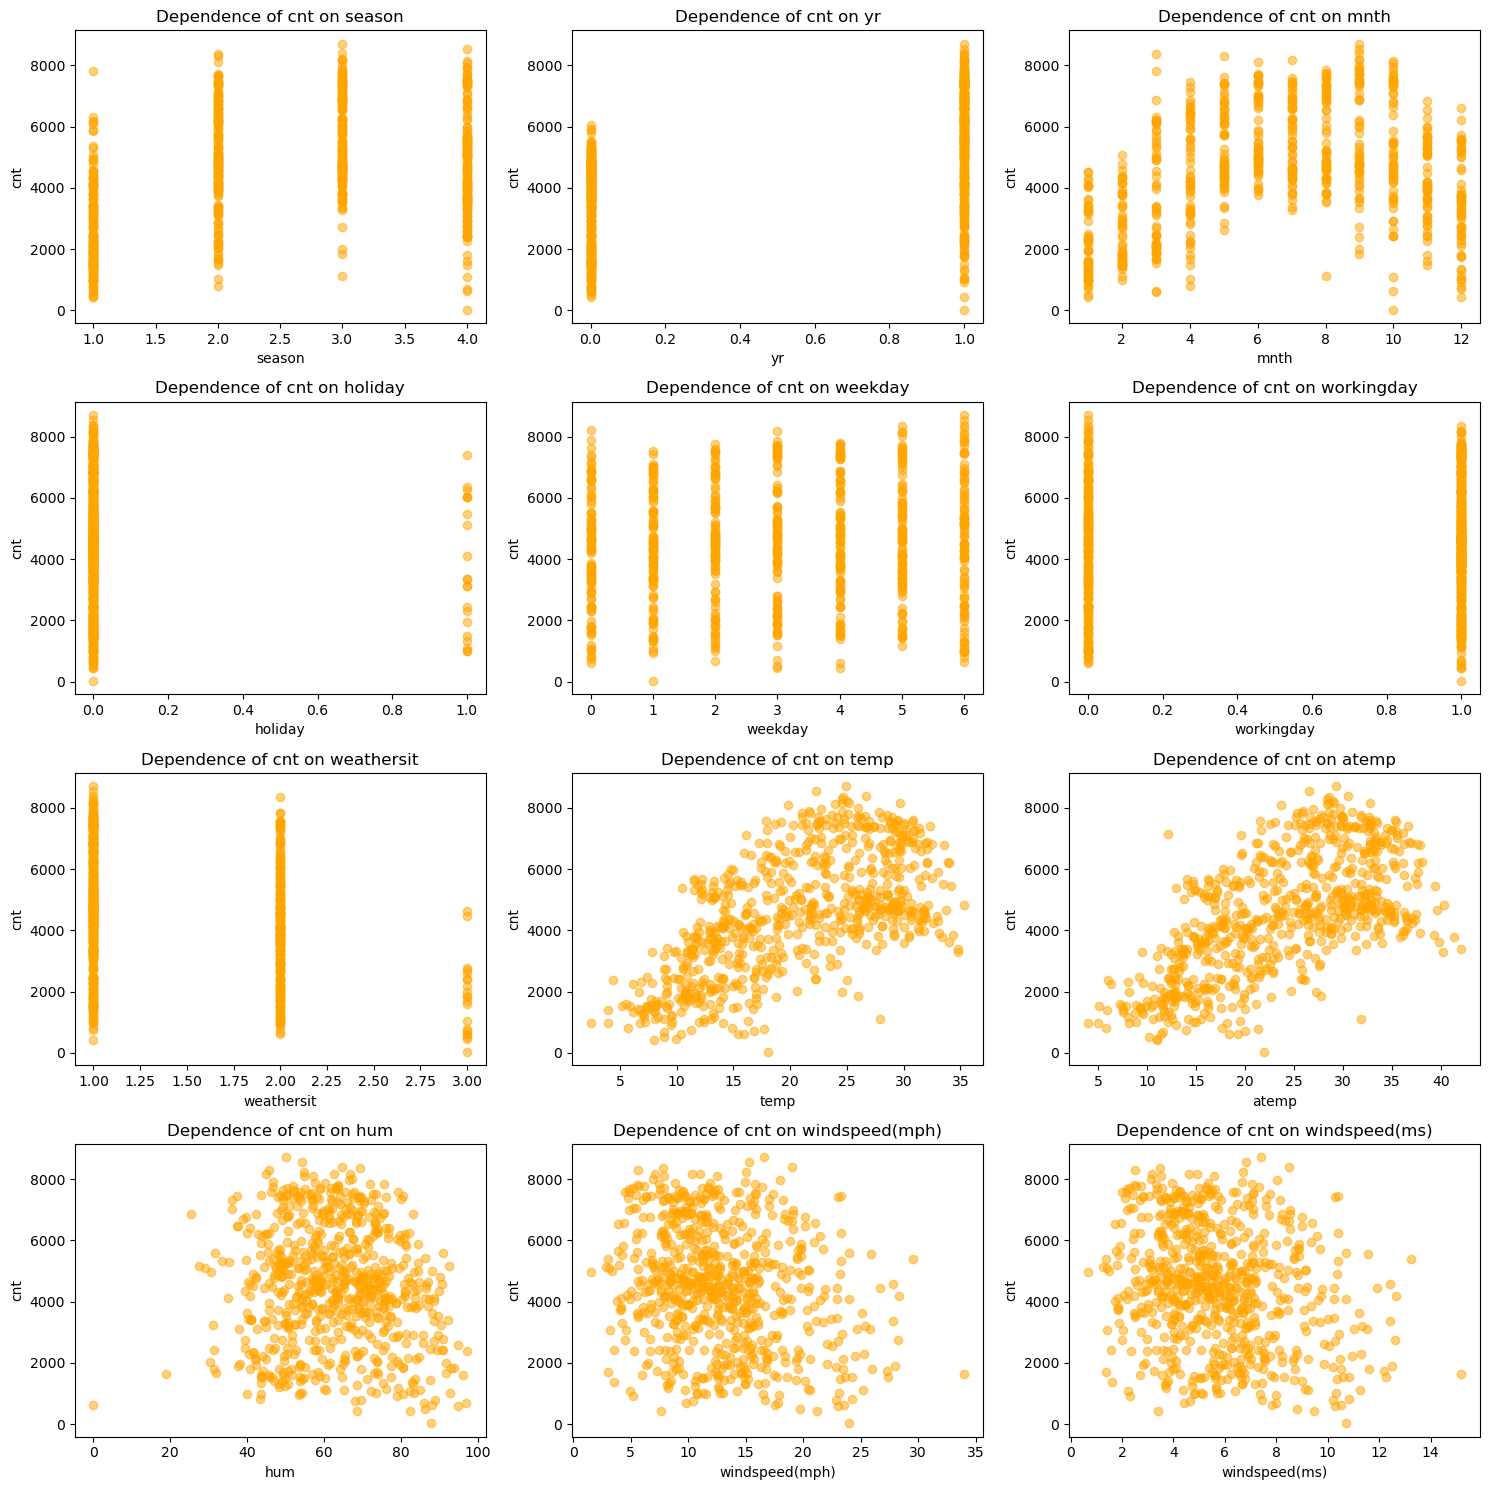

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):
    axes[i].scatter(df[col], df['cnt'], alpha=0.5, color='orange')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('cnt')
    axes[i].set_title(f'Dependence of cnt on {col}')

plt.tight_layout()
plt.show()

__Questions:__
1. What is the nature of the dependence of rentals on the month?
2. Name one or two features that the number of rentals is most likely linearly dependent on.

__Answers:__
1. You can observe a logical seasonality: the colder the month, the fewer rentals.
2. I don't see a linear dependence here. It could be argued that there is a dependence on the year, but we only have two years, and in my opinion, that's not enough to talk about the relevance of the sample. The second feature likely refers to temperature (or perceived temperature), but I'm sure if we take newer data with the condition of rising global temperatures, this graph is a parabola because, above 25 degrees Celsius (which is the peak), the demand for bikes decreases.

## Task 2

Let's more rigorously assess the level of linear dependence between the features and the target variable. A good measure of linear dependence between two vectors is the Pearson correlation. Calculate the correlations of all features, except the last one, with the last one using the `corrwith` method.

In [30]:
correlations = df.corrwith(df['cnt'])
print("Correlations between the features and the variable 'cnt':")
print(correlations)

Correlations between the features and the variable 'cnt':
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
dtype: float64


The dataset contains features that correlate with the target variable, so the task can be solved using linear methods.

The graphs show that some features are similar to each other. Therefore, let's also calculate the correlations between the numerical features.

## Task 3

Calculate the pairwise correlations between the features `temp`, `atemp`, `hum`, `windspeed(mph)`, `windspeed(ms)`, and `cnt` using the `corr` method.

In [32]:
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()
pd.set_option('display.float_format', '{:.2f}'.format)
print("Correlation matrix between numerical features:")
print(correlation_matrix)

Correlation matrix between numerical features:
                temp  atemp   hum  windspeed(mph)  windspeed(ms)   cnt
temp            1.00   0.99  0.13           -0.16          -0.16  0.63
atemp           0.99   1.00  0.14           -0.18          -0.18  0.63
hum             0.13   0.14  1.00           -0.25          -0.25 -0.10
windspeed(mph) -0.16  -0.18 -0.25            1.00           1.00 -0.23
windspeed(ms)  -0.16  -0.18 -0.25            1.00           1.00 -0.23
cnt             0.63   0.63 -0.10           -0.23          -0.23  1.00


The diagonals, as expected, contain ones. However, there are two pairs of highly correlated columns in the matrix: `temp` and `atemp` (correlated by their nature) and the two `windspeed` columns (as they are simply unit conversions of each other). We will see later that this negatively affects the training of the linear model.

Finally, let's look at the means of the features (using the `mean` method) to assess the scale of the features and the proportion of 1s in the binary features.

## Task 4

Display the mean values of the features.

In [33]:
means = df.mean()
print("The mean values of the features:")
print(means)

The mean values of the features:
season              2.50
yr                  0.50
mnth                6.52
holiday             0.03
weekday             3.00
workingday          0.68
weathersit          1.40
temp               20.31
atemp              23.72
hum                62.79
windspeed(mph)     12.76
windspeed(ms)       5.71
cnt              4504.35
dtype: float64


The features have different scales, so it is better to normalize the object-feature matrix for further work.

#### Problem One: Collinear Features

So, in our data, one feature duplicates another, and two more are very similar. Of course, we could immediately remove the duplicates, but let’s see how the model would train if we didn’t notice this issue. First, let’s perform scaling or standardization of the features: subtract the mean from each feature and divide it by the standard deviation. This can be done using the `scale` method. Additionally, it is necessary to shuffle the dataset, as this will be required for cross-validation.

In [35]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Let's train a linear regression model on our data and examine the feature weights.

In [9]:
from sklearn.linear_model import LinearRegression

# Навчання лінійної регресії
X = df.drop(columns=['cnt'])
y = df['cnt']

model = LinearRegression()
model.fit(X, y)

# Виведення ваг моделі
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

season: 514.2757015663954
yr: 2043.937499895518
mnth: -40.96324971851862
holiday: -519.3895390641574
weekday: 68.49560202791295
workingday: 121.29452237198859
weathersit: -606.4602424419659
temp: 48.99734615159841
atemp: 71.91309286915724
hum: -10.23025619299184
windspeed(mph): 2400641438973.261
windspeed(ms): -5370234899067.984


## Task 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [10]:
from sklearn.linear_model import LinearRegression

# Навчання лінійної регресії
X = df.drop(columns=['cnt'])
y = df['cnt']

model = LinearRegression()
model.fit(X, y)

# Виведення ваг моделі
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")

season: 514.2757015663954
yr: 2043.937499895518
mnth: -40.96324971851862
holiday: -519.3895390641574
weekday: 68.49560202791295
workingday: 121.29452237198859
weathersit: -606.4602424419659
temp: 48.99734615159841
atemp: 71.91309286915724
hum: -10.23025619299184
windspeed(mph): 2400641438973.261
windspeed(ms): -5370234899067.984


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

## Task 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [11]:
from sklearn.linear_model import Lasso, Ridge
lasso = Lasso().fit(X, y)
print("Lasso регресія:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef}")

Lasso регресія:
season: 506.5512786498076
yr: 2036.231667697903
mnth: -38.078270289321665
holiday: -484.6519461865403
weekday: 68.93837479133961
workingday: 118.44759758668337
weathersit: -604.5667118927047
temp: 51.36326058561633
atemp: 69.91273749012194
hum: -10.352705204636578
windspeed(mph): -38.34106761310848
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [12]:
ridge = Ridge().fit(X, y)
print("\nRidge регресія:")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef}")


Ridge регресія:
season: 507.8018818505663
yr: 2029.0890541970482
mnth: -38.47089727912177
holiday: -493.2780154838204
weekday: 69.11396965165962
workingday: 121.52442502929445
weathersit: -605.2055553731514
temp: 49.3167675959839
atemp: 71.78598727334911
hum: -10.383394500484695
windspeed(mph): -31.93550169438025
windspeed(ms): -14.276040263628637


## Task 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [13]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha).fit(X, y)
    ridge = Ridge(alpha=alpha).fit(X, y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

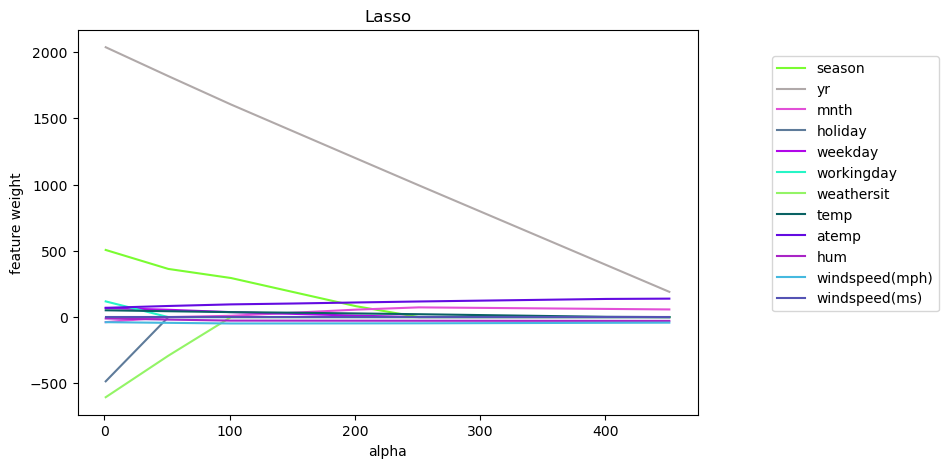

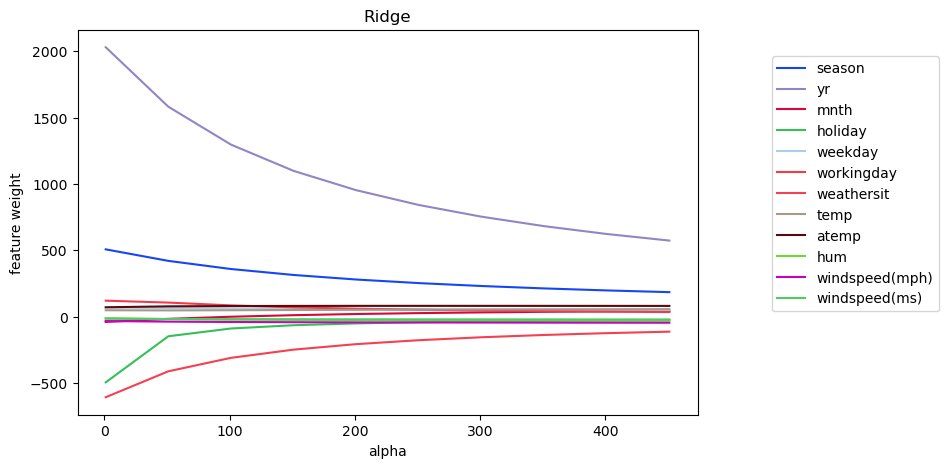

In [14]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?


__Відповіді:__

1. Lasso агресивніше зменшує ваги при тому ж alpha
2. Якщо alpha зробити дуже великим у Lasso, більшість або всі ваги ознак наблизяться до нуля. Це відбувається тому, що L1-регуляризація додає штраф до функції втрат, який пропорційний сумі абсолютних значень коефіцієнтів. Велике значення alpha робить цей штраф настільки значним, що модель прагне зменшити всі коефіцієнти до нуля, щоб мінімізувати загальну вартість функції.
3.
Lasso: Так, можна стверджувати, що Lasso виключає одну з ознак windspeed (зокрема, windspeed(ms)) при значенні alpha > 0, оскільки вже при дуже малих значеннях alpha ваги для windspeed(ms) обнуляються.
Ridge: Ні, Ridge не виключає ознаки повністю. Навіть при великих значеннях alpha ваги для ознак windspeed(mph) і windspeed(ms) залишаються близькими, але не рівними нулю. Це пов'язано з тим, що Ridge накладає штраф на суму квадратів коефіцієнтів, що призводить до зменшення їх значень, але не до повного обнулення.
4. Lasso (L1-регуляризація) підходить краще для відбору неінформативних ознак, оскільки здатний обнулювати ваги неважливих змінних, фактично видаляючи їх з моделі. Ridge (L2-регуляризація) зменшує ваги ознак, але не обнуляє їх повністю.

__Загальний висновок__

На основі графіків можна зробити висновок, що Lasso є кращим інструментом для виключення неінформативних ознак з моделі завдяки його здатності обнулювати ваги. Ridge, натомість, більше підходить для моделей, де всі ознаки важливі, але можуть мати занадто великі або малі коефіцієнти, які потребують коригування.

P.S. Я аналізував і свої графіки, і ті, які були першочергово. Чому відрізняються - не розумію.

## Task 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [15]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [16]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

# Навчання регресора з крос-валідацією
regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

# Усереднений MSE для кожного alpha
mse_means = np.mean(regressor.mse_path_, axis=1)

# Вивід вибраного alpha та коефіцієнтів
print("Вибране значення alpha:", regressor.alpha_)
print("Коефіцієнти:")

for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Вибране значення alpha: 1
Коефіцієнти:
season: 506.5512786498076
yr: 2036.231667697903
mnth: -38.078270289321665
holiday: -484.6519461865403
weekday: 68.93837479133961
workingday: 118.44759758668337
weathersit: -604.5667118927047
temp: 51.36326058561633
atemp: 69.91273749012194
hum: -10.352705204636578
windspeed(mph): -38.34106761310848
windspeed(ms): -0.0


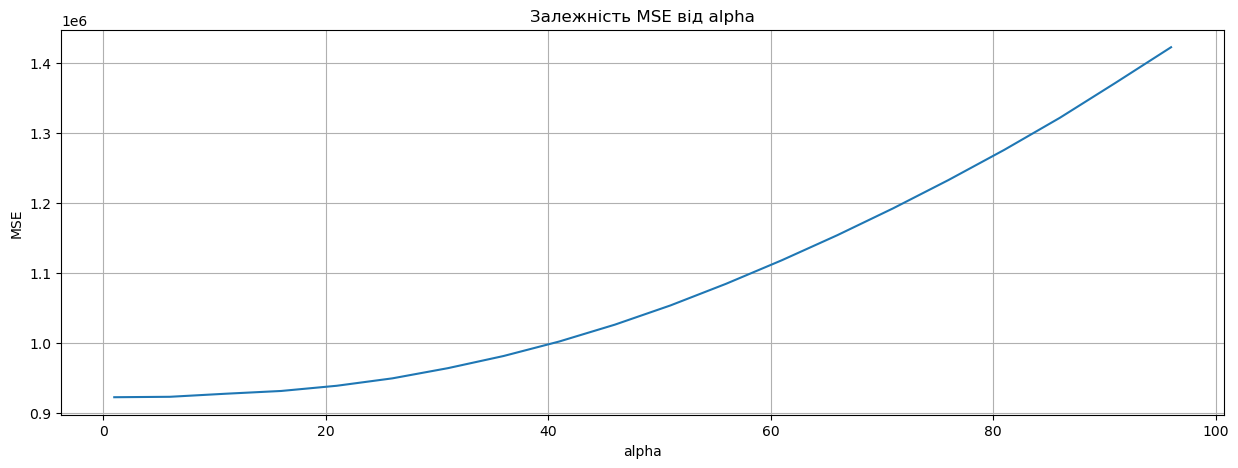

In [17]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # Перетворення map-об'єктів на списки для побудови графіку
    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

# Створення графіка залежності MSE від alpha
create_plot(list(zip(regressor.alphas_, mse_means)), title="Залежність MSE від alpha", xlabel="alpha", ylabel="MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

## Task 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Значення alpha, що відповідають мінімумам MSE на кожному розбитті:
Розбиття 1: Alpha = 1, MSE = 783221.2007323343
Розбиття 2: Alpha = 51, MSE = 606705.6506735523
Розбиття 3: Alpha = 1, MSE = 1234577.1775608317


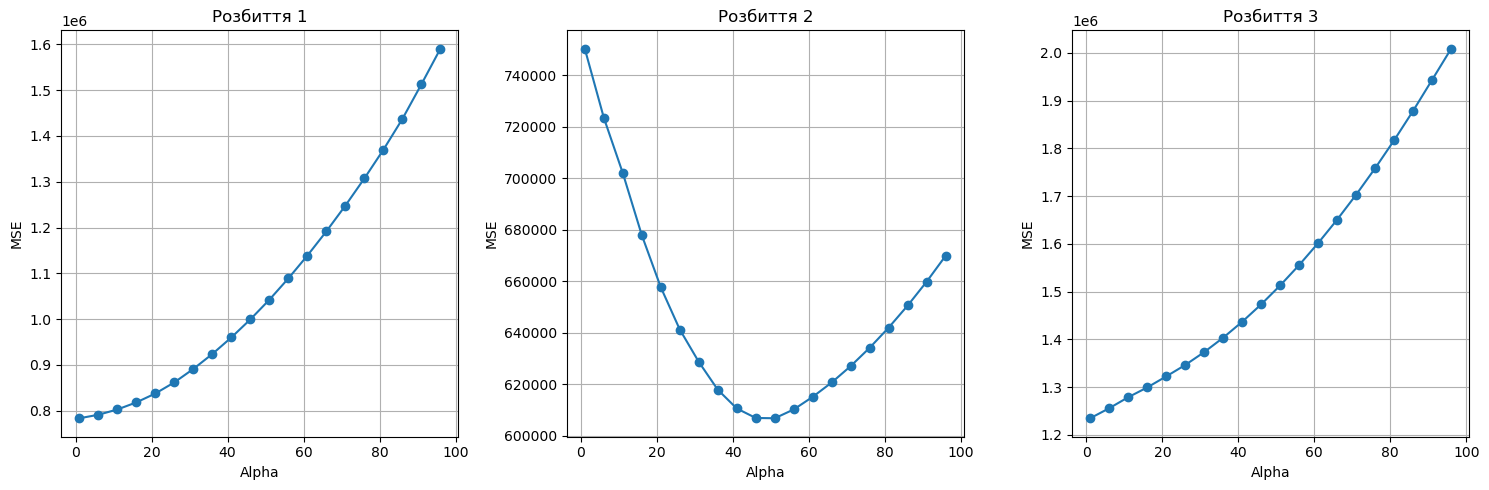

In [18]:
alphas_min_mse = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
mse_min_values = np.min(regressor.mse_path_, axis=0)

print("Значення alpha, що відповідають мінімумам MSE на кожному розбитті:")
for i, (alpha, mse) in enumerate(zip(alphas_min_mse, mse_min_values)):
    print(f"Розбиття {i+1}: Alpha = {alpha}, MSE = {mse}")

# Візуалізація MSE для кожного розбиття
plt.figure(figsize=(15, 5))

# Побудуйте графік для кожного з трьох розбиттів
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], marker='o')
    plt.title(f'Розбиття {i+1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid(True)

plt.tight_layout()
plt.show()



На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

## Task 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Найбільші позитивні коефіцієнти мають ознаки:
yr: 2036.23
season: 506.55
workingday: 118.45
weekday: 68.94
yr: Коефіцієнт при yr (рік) є найбільшим. Це означає, що в 2012 році (позначається як 1) кількість прокатів велосипедів значно більша, ніж в 2011 році (позначається як 0). Це логічно, оскільки, з огляду на розвиток системи прокату, кількість прокатів може збільшуватись з часом.

season: season має другий за величиною позитивний коефіцієнт. Це означає, що кількість прокатів зростає в певні сезони, наприклад, літом або весною, коли погода краще і більше людей хочуть взяти велосипеди. Це також логічно, виходячи зі здорового глузду.

workingday: Позитивний коефіцієнт для workingday означає, що в робочі дні кількість прокатів велосипедів зростає. Це може бути пов'язано з використанням велосипедів як транспорту для поїздок на роботу.

weekday: Позитивний коефіцієнт для weekday вказує на зростання кількості прокатів залежно від дня тижня. Залежність може бути слабшою, але вона все ще показує, що певні дні тижня (наприклад, середина тижня) можуть бути більш популярними для прокатів.

Висновок: Так, можна стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди. Це відповідає здоровому глузду і підтверджується графіками.



#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Найбільші за модулем негативні коефіцієнти мають ознаки:
weathersit: -604.57
holiday: -484.65
windspeed(mph): -38.34
Аналіз:

weathersit: Негативний коефіцієнт вказує на те, що коли погода погіршується (значення weathersit збільшується), кількість прокатів зменшується. Це логічно, оскільки в погану погоду (наприклад, дощ або туман) менше людей захочуть брати велосипеди.

holiday: Негативний коефіцієнт для holiday означає, що у святкові дні кількість прокатів зменшується. Це може бути пов'язано з тим, що люди менше подорожують у святкові дні або використовують інші засоби транспорту.

windspeed(mph): Негативний коефіцієнт для швидкості вітру (windspeed) показує, що при збільшенні швидкості вітру кількість прокатів зменшується. Це теж логічно, адже сильний вітер може зробити поїздку на велосипеді менш комфортною.

Висновок: Так, можна стверджувати, що чим більше значення цих ознак, тим менше людей захочуть взяти велосипеди. Це відповідає реальному життю і підтверджується графіками.

In [19]:
# ???

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

windspeed(ms): -0.0
Аналіз:

windspeed(ms) має коефіцієнт, рівний -0. Це означає, що модель виключила цю ознаку, оскільки вона повністю корелює з ознакою windspeed(mph) (швидкість вітру в милях за годину). Обидві ознаки передають ту саму інформацію, лише в різних одиницях, тому модель залишила тільки одну з них (windspeed(mph)).
Висновок: Ознака windspeed(ms) не впливає на попит на велосипеди, оскільки її інформація вже врахована іншою ознакою windspeed(mph).

In [20]:
# ???

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.